In [39]:
%pip install pyyaml==6.0.1
%pip install pycocotools>=2.0.7
%pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
%pip install opencv-python
%pip install tensorboard
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation becaus

In [40]:
import os
import json
import random
import cv2
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import tensorboard
import pandas as pd
from matplotlib import pyplot as plt
from torch import __version__ as torch_ver
from detectron2 import __version__ as detectron_ver
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
setup_logger()

<Logger detectron2 (DEBUG)>

In [41]:
TORCH_VERSION = ".".join(torch_ver.split(".")[:2])
CUDA_VERSION = torch_ver.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron_ver)
print("gpu:", torch.cuda.is_available())

torch:  2.2 ; cuda:  cu121
detectron2: 0.6
gpu: True


In [42]:
MODEL = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
OUTPUT_DIR = "./output"
DATASET_NAME = "agar_coco_dataset"
DATASET_PATH = "./DATASET_BIG/dataset/"
ANNOTATION_FILE_PATH = "./DATASET_BIG/dataset/annotations.json"
TRAINING_LISTS_PATH = "./DATASET_BIG/training_lists/"

In [43]:
# !unzip -o ./NOTEBOOK/DATASETS.zip -d ./

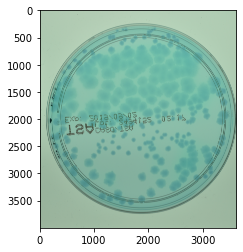

In [44]:
im = cv2.imread(f"{DATASET_PATH}{random.randint(1, 18000)}.jpg")
plt.imshow(im)
plt.show()

In [45]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [57.375, 57.12, 58.395], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_T

In [46]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/05 13:10:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...


In [47]:
print("pred_boxes:", outputs["instances"].pred_boxes)
print("scores:", outputs["instances"].scores)
print("pred_classes:", outputs["instances"].pred_classes)

pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4)))
scores: tensor([], device='cuda:0')
pred_classes: tensor([], device='cuda:0', dtype=torch.int64)


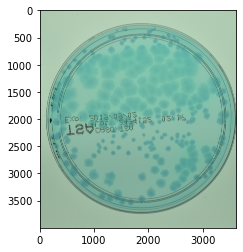

In [48]:
v = Visualizer(
    im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [49]:
agar_coco_full_dataset = load_coco_json(json_file=ANNOTATION_FILE_PATH,
                                        image_root=DATASET_PATH,
                                        dataset_name=DATASET_NAME)

[04/05 13:10:12 d2.data.datasets.coco]: Loading ./DATASET_BIG/dataset/annotations.json takes 3.18 seconds.
[04/05 13:10:12 d2.data.datasets.coco]: Loaded 18000 images in COCO format from ./DATASET_BIG/dataset/annotations.json


In [50]:
def get_ids_by_train_list(training_list_path: str) -> list[dict]:
    with open(training_list_path, 'r') as f:
        data = f.read()
    j = json.loads(data)
    str_ids = [num for num in j if num != 'annotations.json']
    ids = [int(num) for num in str_ids]
    return ids


def filter_dataset_by_ids(dataset: list[dict], ids: list[int]) -> list[dict]:
    return [ann for ann in dataset if ann['image_id'] in ids]

In [51]:
high_res_train_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_train.txt"
low_res_train_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_train.txt"
vague_train_list_path = f"{TRAINING_LISTS_PATH}vague_train.txt"
high_res_val_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_val.txt"
low_res_val_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_val.txt"
vague_val_list_path = f"{TRAINING_LISTS_PATH}vague_val.txt"

In [52]:
get_ids_by_train_list(high_res_train_list_path)[:5], get_ids_by_train_list(
    low_res_train_list_path)[:5], get_ids_by_train_list(vague_train_list_path)[:5]

([3382, 6923, 593, 1200, 4373],
 [16078, 16831, 16073, 16072, 16830],
 [11829, 11828, 11825, 11824, 11827])

In [53]:
# делим на тренировочный и тестовый датасеты с изображениями
# высокого качества, низкого качества и расплывчатые (всего 6)
for k, v in {"high_res_train": high_res_train_list_path,
             "low_res_train": low_res_train_list_path,
             "vague_train": vague_train_list_path,
             "high_res_val": high_res_val_list_path,
             "low_res_val": low_res_val_list_path,
             "vague_val": vague_val_list_path}.items():
    name = f"{DATASET_NAME}_{k}"
    try:
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    except:
        pass
    print("Registering '{}' DatasetCatalog by path {}".format(name, v))
    DatasetCatalog.register(name, lambda v=v:
                            filter_dataset_by_ids(dataset=agar_coco_full_dataset,
                                                  ids=get_ids_by_train_list(v)))
    MetadataCatalog.get(name).set(thing_classes=["S.aureus", "B.subtilis", "P.aeruginosa", "E.coli", "C.albicans", "Defect", "Contamination"])
    MetadataCatalog.get(name).set(json_file=ANNOTATION_FILE_PATH)
    MetadataCatalog.get(name).set(image_root=DATASET_PATH)
    MetadataCatalog.get(name).set(evaluator_type='coco')
    print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
        name, len(DatasetCatalog.get(name))))
    print("Metadata of {}: {}\n".format(name, MetadataCatalog.get(name)))

Registering 'agar_coco_dataset_high_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/higher_resolution_train.txt
Successfully registered 'agar_coco_dataset_high_res_train' DatasetCatalog containing 5241 indices
Metadata of agar_coco_dataset_high_res_train: Metadata(name='agar_coco_dataset_high_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans', 'Defect', 'Contamination'], json_file='./DATASET_BIG/dataset/annotations.json', image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_low_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/lower_resolution_train.txt
Successfully registered 'agar_coco_dataset_low_res_train' DatasetCatalog containing 3318 indices
Metadata of agar_coco_dataset_low_res_train: Metadata(name='agar_coco_dataset_low_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans', 'Defect', 'Contamination'], json_file='./DATASET_BIG/dataset

In [54]:
# объединение всех валидационных датасетов в один
name = f"{DATASET_NAME}_all_val"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except:
    pass
print("Registering '{}' DatasetCatalog by path {}".format(name, v))
DatasetCatalog.register(name, lambda: DatasetCatalog.get(f"{DATASET_NAME}_low_res_val") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_val") + DatasetCatalog.get(f"{DATASET_NAME}_vague_val"))
MetadataCatalog.get(name).set(thing_classes=["S.aureus", "B.subtilis", "P.aeruginosa", "E.coli", "C.albicans", "Defect", "Contamination"])
MetadataCatalog.get(name).set(json_file=ANNOTATION_FILE_PATH)
MetadataCatalog.get(name).set(image_root=DATASET_PATH)
MetadataCatalog.get(name).set(evaluator_type='coco')
print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
    name, len(DatasetCatalog.get(name))))
MetadataCatalog.get(name)

Registering 'agar_coco_dataset_all_val' DatasetCatalog by path ./DATASET_BIG/training_lists/vague_val.txt
Successfully registered 'agar_coco_dataset_all_val' DatasetCatalog containing 3067 indices


namespace(name='agar_coco_dataset_all_val',
          thing_classes=['S.aureus',
                         'B.subtilis',
                         'P.aeruginosa',
                         'E.coli',
                         'C.albicans',
                         'Defect',
                         'Contamination'],
          json_file='./DATASET_BIG/dataset/annotations.json',
          image_root='./DATASET_BIG/dataset/',
          evaluator_type='coco')

In [55]:
# объединение всех тренировочных датасетов в один
name = f"{DATASET_NAME}_all_train"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except:
    pass
print("Registering '{}' DatasetCatalog by path {}".format(name, v))
DatasetCatalog.register(name, lambda: DatasetCatalog.get(f"{DATASET_NAME}_low_res_train") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_train") + DatasetCatalog.get(f"{DATASET_NAME}_vague_train"))
MetadataCatalog.get(name).set(thing_classes=["S.aureus", "B.subtilis", "P.aeruginosa", "E.coli", "C.albicans", "Defect", "Contamination"])
MetadataCatalog.get(name).set(json_file=ANNOTATION_FILE_PATH)
MetadataCatalog.get(name).set(image_root=DATASET_PATH)
MetadataCatalog.get(name).set(evaluator_type='coco')
print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
    name, len(DatasetCatalog.get(name))))
MetadataCatalog.get(name)

Registering 'agar_coco_dataset_all_train' DatasetCatalog by path ./DATASET_BIG/training_lists/vague_val.txt
Successfully registered 'agar_coco_dataset_all_train' DatasetCatalog containing 9202 indices


namespace(name='agar_coco_dataset_all_train',
          thing_classes=['S.aureus',
                         'B.subtilis',
                         'P.aeruginosa',
                         'E.coli',
                         'C.albicans',
                         'Defect',
                         'Contamination'],
          json_file='./DATASET_BIG/dataset/annotations.json',
          image_root='./DATASET_BIG/dataset/',
          evaluator_type='coco')

./DATASET_BIG/dataset/16678.jpg


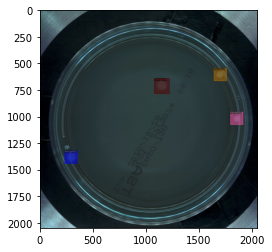

In [56]:
# To verify the dataset is in correct format,
# let's visualize the annotations of randomly selected samples in the training set
for d in random.sample(DatasetCatalog.get(f"{DATASET_NAME}_all_train"), 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=MetadataCatalog.get(f"{DATASET_NAME}_all_train"),
                            scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [57]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_high_res_train",
                      f"{DATASET_NAME}_low_res_train",
                      f"{DATASET_NAME}_vague_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 30000
cfg.TEST.DETECTIONS_PER_IMAGE = 300
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # под вопросом
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [58]:
%ls ./output

coco_instances_results.json                         model_0009999.pth
events.out.tfevents.1712268189.rentserver.115560.0  model_0014999.pth
events.out.tfevents.1712268511.rentserver.116863.0  model_0019999.pth
instances_predictions.pth                           model_0024999.pth
last_checkpoint                                     model_0029999.pth
metrics.json                                        model_final.pth
model_0004999.pth


In [59]:
%reload_ext tensorboard
%tensorboard --logdir ./output --bind_all

Reusing TensorBoard on port 6006 (pid 109214), started 1 day, 11:57:43 ago. (Use '!kill 109214' to kill it.)

In [60]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

print(f"Start training on {cfg.MODEL.DEVICE}")
trainer.train()

[04/05 13:10:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [61]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/05 13:10:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


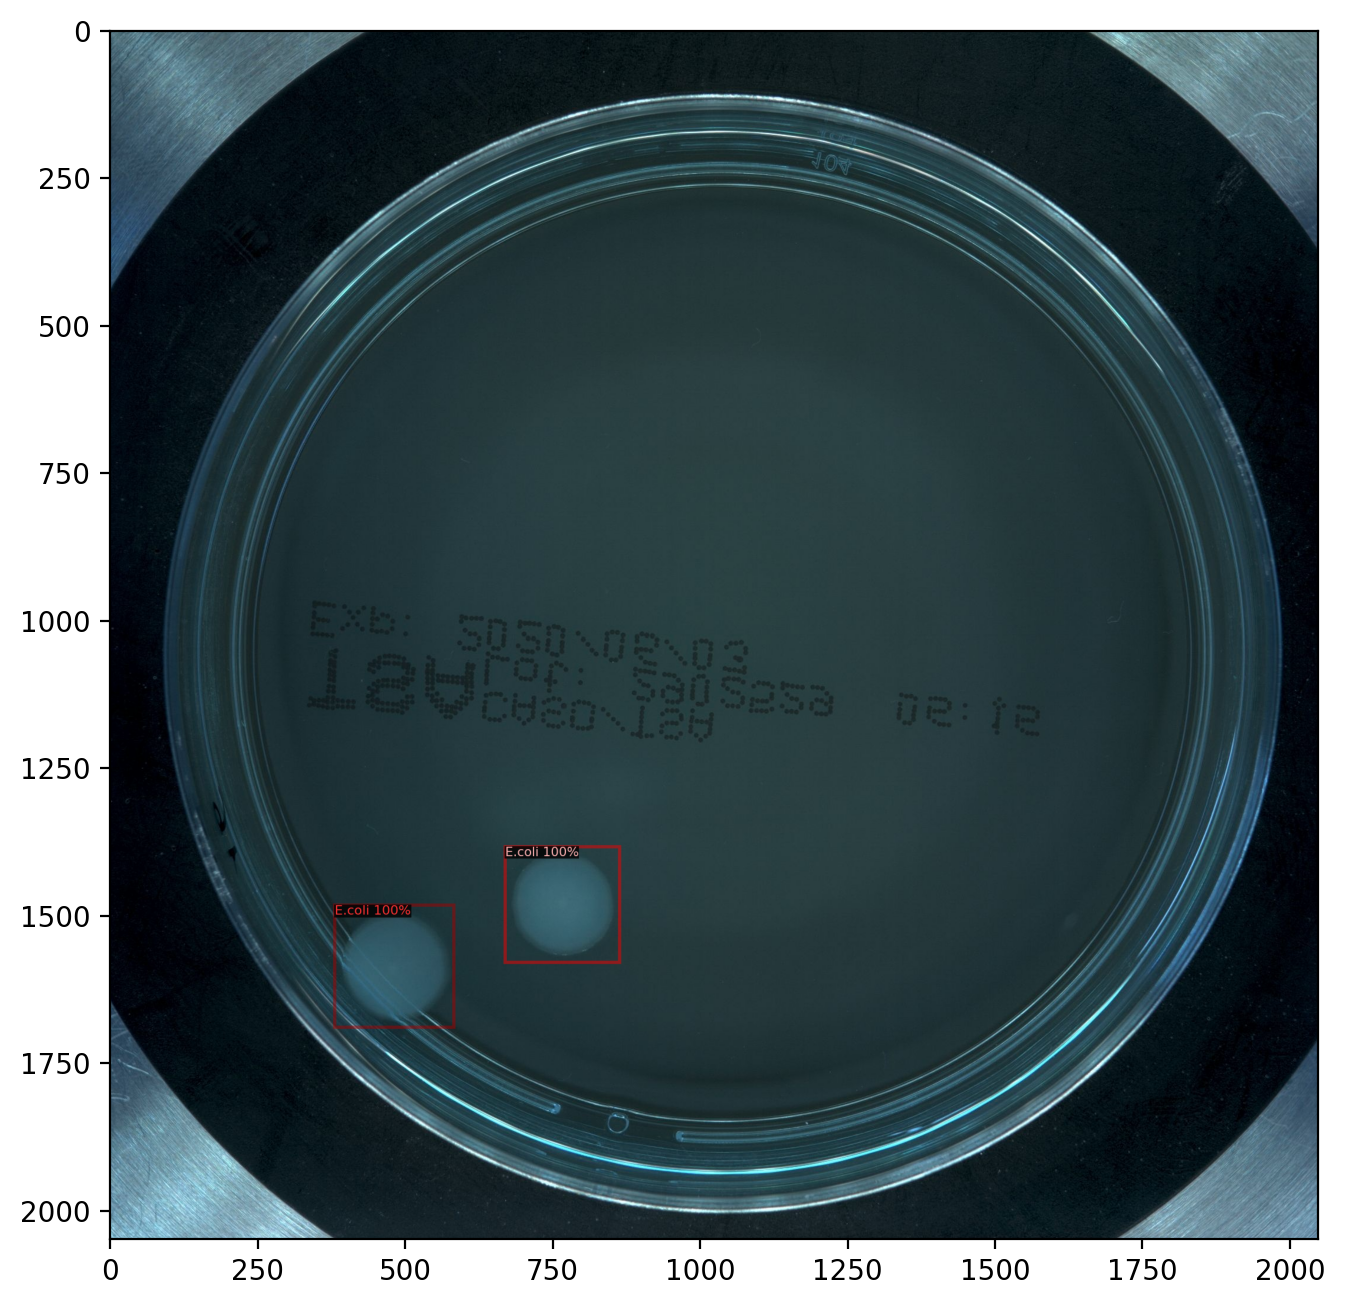

In [62]:
all_train_metadata = MetadataCatalog.get(f"{DATASET_NAME}_all_train")
all_val_dataset = DatasetCatalog.get(f"{DATASET_NAME}_all_val")

for d in random.sample(list(all_val_dataset), 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=all_train_metadata,
                   scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(8, 8), dpi=200)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [65]:
def evaluate(ds_name):
    evaluator = COCOEvaluator(ds_name, output_dir=OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, ds_name)
    inference_result = inference_on_dataset(predictor.model, val_loader, evaluator)
    return inference_result

In [66]:
low_res_inference_result = evaluate(f"{DATASET_NAME}_low_res_val")
# high_res_inference_result = evaluate(f"{DATASET_NAME}_high_res_val")
# vague_inference_result = evaluate(f"{DATASET_NAME}_vague_val")

[04/05 13:24:50 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/05 13:24:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/05 13:24:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/05 13:24:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/05 13:24:55 d2.data.common]: Serializing 1106 elements to byte tensors and concatenating them all ...
[04/05 13:24:55 d2.data.common]: Serialized dataset takes 1.54 MiB
[04/05 13:24:55 d2.evaluation.evaluator]: Start inference on 1106 batches
[04/05 13:24:57 d2.evaluation.evaluator]: Inference done 11/1106. Dataloading: 0.0014 s/iter. Inference: 0.1032 s/iter. Eval: 0.0004 s/iter. Total: 0.1050 s/iter. ETA=0:01:5

In [67]:
pd.DataFrame(low_res_inference_result), pd.DataFrame(
    high_res_inference_result), pd.DataFrame(vague_inference_result)

(                      bbox
 AP                2.710695
 AP-B.subtilis     2.721359
 AP-C.albicans     3.490165
 AP-Contamination  0.000000
 AP-Defect         0.000000
 AP-E.coli         5.208666
 AP-P.aeruginosa   4.115035
 AP-S.aureus       3.439636
 AP50              4.081157
 AP75              3.083344
 APl               1.665941
 APm               3.064543
 APs               1.192399,
                        bbox
 AP                 6.392100
 AP-B.subtilis     12.234538
 AP-C.albicans      6.731985
 AP-Contamination   0.000000
 AP-Defect          0.000000
 AP-E.coli          8.886927
 AP-P.aeruginosa    9.877948
 AP-S.aureus        7.013301
 AP50              10.262564
 AP75               6.880985
 APl                7.229742
 APm                4.278368
 APs                0.610449,
                       bbox
 AP                0.655841
 AP-B.subtilis     0.000000
 AP-C.albicans     0.000000
 AP-Contamination  0.000000
 AP-Defect         0.000000
 AP-E.coli         1.590009
 AP-